# ACOM of AuAgPd nanowires - disk detection

This notebook performs disk detection for the AuAgPd nanowire 4D-STEM bullseye experiment. The data has been downsampled for the purposes of the tutorial.

Our goal is to perform automated crystal orientation mapping (ACOM), as described in: <br>
[Automated Crystal Orientation Mapping in py4DSTEM using Sparse Correlation Matching](https://doi.org/10.1017/S1431927622000101)

### Data

[small_AuAgPd_wire_dataset_04.h5](https://drive.google.com/file/d/1OQYW0H6VELsmnLTcwicP88vo2V5E3Oyt/view?usp=sharing) (2.0 GB)

[downsampled_AuAgPd_wire_probe.h5](https://drive.google.com/file/d/17OduUKpxVBDumSK_VHtnc2XKkaFVN8kq/view?usp=sharing)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Alex Rakowski (arakowski@lbl.gov)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Colin Ophus (clophus@lbl.gov)

Experimental data was collected by Alexandra Bruefach (abruefach@berkeley.edu )

### pymatgen

We use the python package pymatgen for various symmetry calculations of crystals in py4DSTEM. The ACOM module of py4DSTEM can be used without pymatgen, but with substantially reduced functionality. We therefore recommend installing pymatgen if you wish to perform ACOM calculations.

In [2]:
import py4DSTEM
import numpy as np
print(py4DSTEM.__version__)

0.13.6


In [3]:
# file_path_data = r'C:\data\4DSTEM\tutorial\small_AuAgPd_wire_dataset_04.h5'
# file_path_probe = r'C:\data\4DSTEM\tutorial\downsampled_AuAgPd_wire_probe.h5'
# file_path_analysis = r'C:\data\4DSTEM\tutorial\AuAgPd_wire_analysis_'
file_path_data = '/media/cophus/DataSSD1/data/small_AuAgPd_wire_dataset_04.h5'
file_path_probe = '/media/cophus/DataSSD1/data/downsampled_AuAgPd_wire_probe.h5'
file_path_analysis = '/media/cophus/DataSSD1/data/AuAgPd_analysis_'

# Load Datasets

In [4]:
# Load the datacubes using py4DSTEM
dataset = py4DSTEM.read(file_path_data, data_id='datacube_0')
dataset_probe = py4DSTEM.read(file_path_probe, data_id='datacube_0')

In [5]:
# Display some information for the loaded files
dataset, dataset_probe

(DataCube( A 4-dimensional array of shape (62, 143, 172, 172) called 'datacube_0',
           with dimensions:
 
           Rx = [0,1,...] pixels
           Ry = [0,1,...] pixels
           Qx = [0,1,...] pixels
           Qy = [0,1,...] pixels
 ),
 DataCube( A 4-dimensional array of shape (5, 16, 172, 172) called 'datacube_0',
           with dimensions:
 
           Rx = [0,1,...] pixels
           Ry = [0,1,...] pixels
           Qx = [0,1,...] pixels
           Qy = [0,1,...] pixels
 ))

In [6]:
# Let's add the pixel sizes from the original .dm4 file to this dataset (this step will be automated during data load in the new future)

pixel_size_inv_Ang = 0.021
probe_step_size_Ang = 5.0

# Diffraction space
dataset.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
dataset.calibration.set_Q_pixel_units('A^-1')
dataset_probe.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
dataset_probe.calibration.set_Q_pixel_units('A^-1')

# Real space
dataset.calibration.set_R_pixel_size(probe_step_size_Ang)
dataset.calibration.set_R_pixel_units('A')


In [7]:
# Calculate these images:
#     -max diffraction pattern from dataset
#     -mean diffraction pattern from dataset
#     -mean diffraction pattern from probe
dataset.get_dp_max();
dataset.get_dp_mean();
dataset_probe.get_dp_mean();

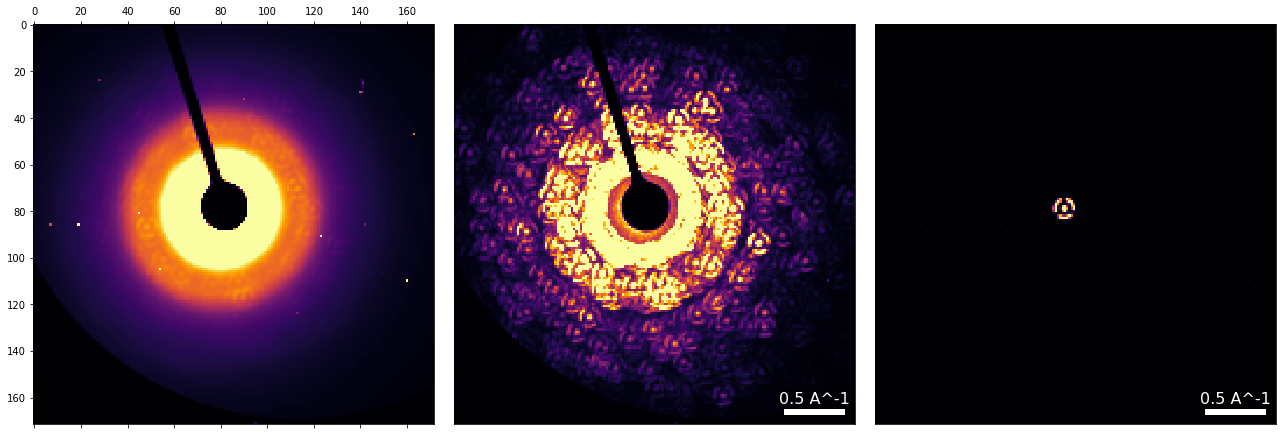

In [8]:
py4DSTEM.visualize.show_image_grid(
    lambda i:[
#         dataset.tree['dp_mean'], 
        dataset.tree['dp_mean'].data * 10, 
        dataset.tree['dp_max'], 
        dataset_probe.tree['dp_mean'],
    ][i],
    H=1,
    W=3,
    cmap='inferno',
    clipvals='manual',
    vmin=0,
    vmax=1500,
)

In [9]:
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.021
             R_pixel_size:    5.0
             Q_pixel_units:   A^-1
             R_pixel_units:   A
)

# Virtual images

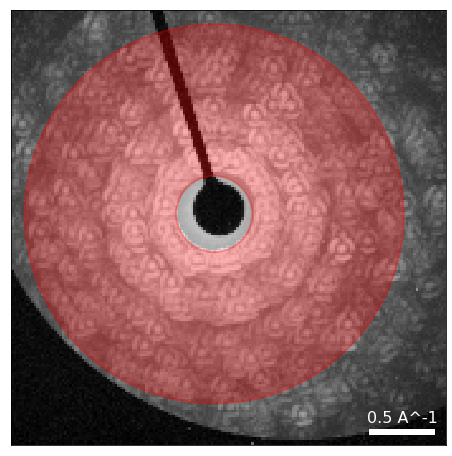

100%|████████████████████████████████████████████████████████████████████████████| 8866/8866 [00:00<00:00, 17333.50it/s]


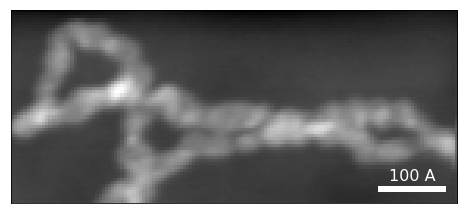

In [10]:
# Create an annular dark field (ADF) virtual detector using user-chosen values:
center = (80,80)
radii = (15,75)

# Plot the ADF detector
py4DSTEM.visualize.show(
    dataset.tree['dp_max'], 
    scaling='log',
    annulus = {
      'center':center,
      'radii':radii,
      'alpha':0.3,
      'fill':True
    }
)

# Calculate the ADF image
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = ((center),radii),
    name = 'dark_field',
)

# Plot the ADF image
py4DSTEM.visualize.show(
    dataset.tree['dark_field'],
)

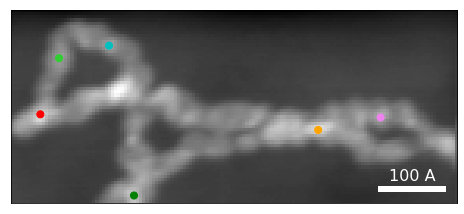

In [11]:
# Choose some diffraction patterns to use for hyperparameter tuning

rxs = 33,15,11,59,38,34
rys = 9,15,31,39,98,118,
colors=['r','limegreen','c','g','orange', 'violet']

py4DSTEM.visualize.show_points(
    dataset.tree['dark_field'],
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# Construct Probe Template

In [12]:
# Align the probe images (this is not necessary if you don't scan while recording a vacuum probe).
# Note that we need to use a low threshold to make this function work with a bullseye probe.

probe_align = py4DSTEM.process.probe.get_probe_from_vacuum_4Dscan(
    dataset_probe,
    mask_threshold = 0.02,
    align = True,
)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.75it/s]


Estimated probe radius = 4.96 pixels


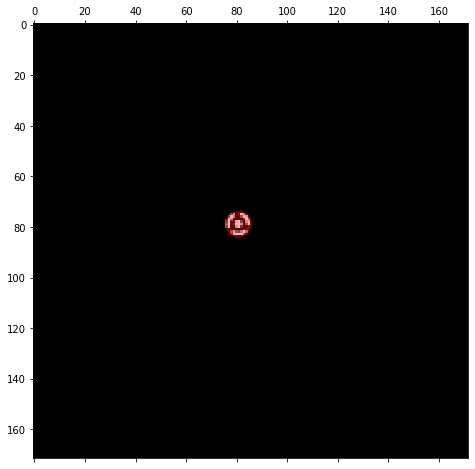

In [13]:
# Estimate the semiangle (radius) of the probe, and the center coordinates.
# Note that we need to lower the thresholds to make the get_probe_size() function work with a bullseye probe.

probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(
    probe_align,
    thresh_lower = 0.02,
    thresh_upper = 0.04,
)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
fig, ax = py4DSTEM.visualize.show_circles(
    probe_align, 
    (probe_qx0, probe_qy0), 
    probe_semiangle,
    clipvals='manual',
    vmin=0,
    vmax=1500, 
    returnfig=True,
)

# uncomment these lines to zoom in
# ax.set_xlim([60, 105])
# ax.set_ylim([100, 55])

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

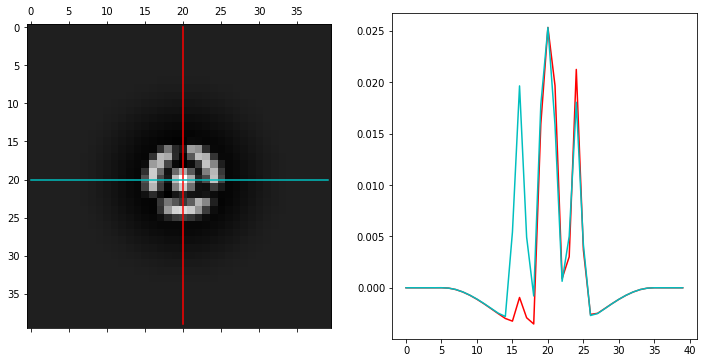

In [14]:
# Construct a probe template to use as a kernel for correlation disk detection

probe_kernel = py4DSTEM.process.probe.get_probe_kernel_edge_sigmoid(
    probe_align,
    (probe_semiangle * 0.0, probe_semiangle * 3.0),
    bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=20, 
    L=20, 
    W=1)

# Disk detection

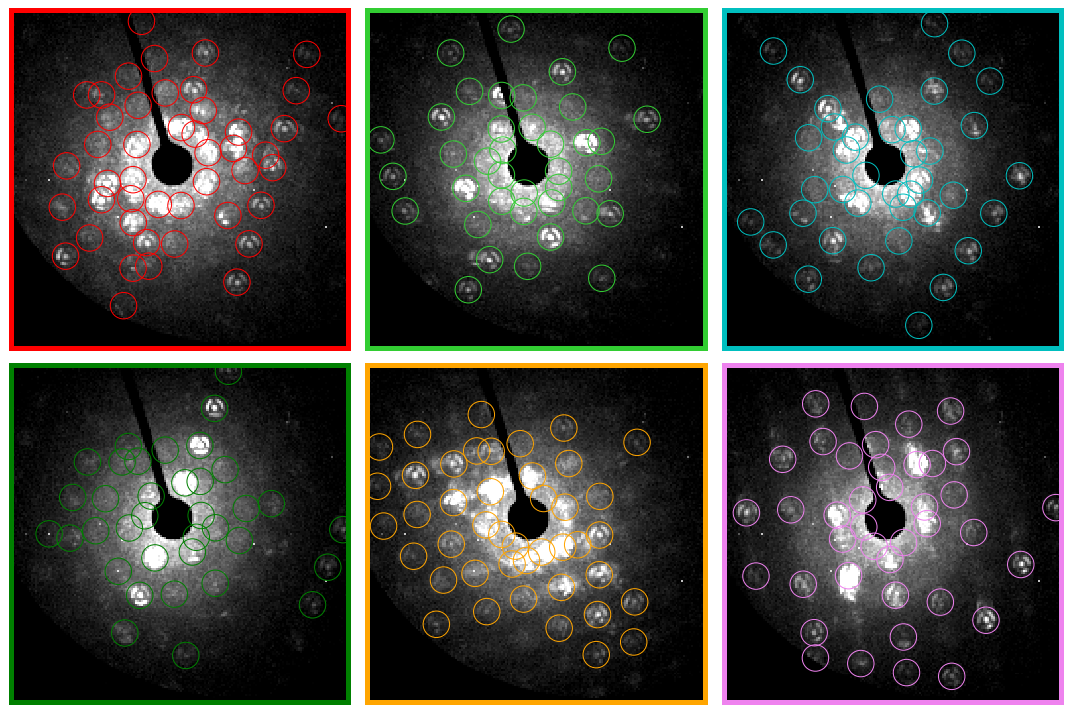

In [15]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 2,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 8,
    'minPeakSpacing': 8,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    clipvals='manual',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [16]:
# Find all Bragg peaks
# Note that here we have used "poly" disk detection, which is much faster, but less accurate.
# We do not need extremely precise peak locations to perform an ACOM analysis.

bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████| 8.87k/8.87k [00:54<00:00, 163DP/s]


In [17]:
# Save Bragg disk positions
file_name_braggdisks_raw = file_path_analysis + 'braggdisks_raw.h5'
py4DSTEM.save(
    file_name_braggdisks_raw,
    bragg_peaks,
    mode='o',
)

100%|█████████████████████████████████████████████████████████████████████████████| 8866/8866 [00:01<00:00, 5707.63it/s]


# Remove false positives due to beamstop 

Many 4DSTEM experiments require a beamstop to prevent damage or saturation on the detector.  In the above experiment, the beamstop has produced a ring of false positives around the center, and along the beamstop arm.  Here, we filter and remove them.

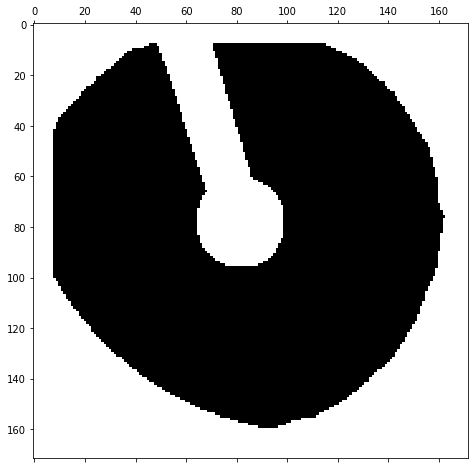

In [18]:
# First, generate a mask of the beamstop, plot it
dataset.get_beamstop_mask(
    threshold = 0.25,
    distance_edge = 8,
);

py4DSTEM.show(
    dataset.tree["mask_beamstop"],
    clipvals='manual',
    vmin=0,
    vmax=1,
)

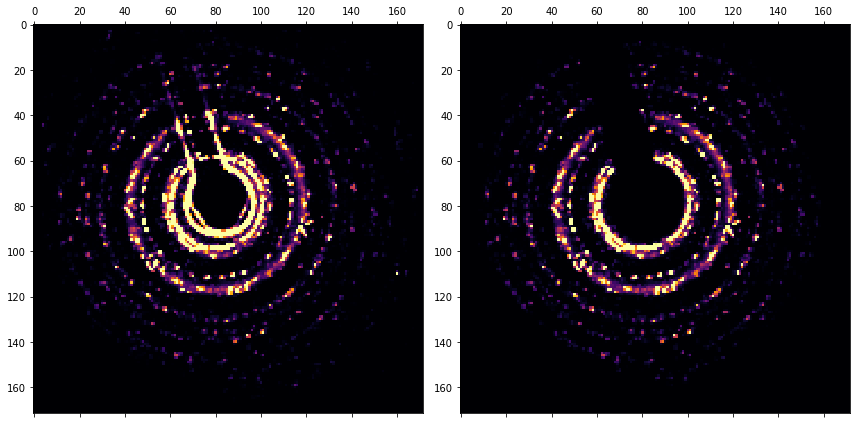

In [19]:
# Apply the mask to the raw bragg peaks
bragg_peaks_masked = bragg_peaks.get_masked_peaks(
    dataset.tree["mask_beamstop"].data,
)

# Create a bragg vector map (2D histogram of all detected bragg peaks) for both raw and masked Bragg peaks
bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw')

# Plot a
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:[bragg_vector_map, bragg_vector_map_masked][i],
    H=1, 
    W=2,
    clipvals = 'manual',
    vmin = 0,
    vmax = 2000,
    cmap = 'inferno',
    figsize=(16,8),
) 

In [20]:
# Save masked Bragg peaks
file_name_braggdisks_masked = file_path_analysis + 'braggdisks_masked.h5'
py4DSTEM.save(
    file_name_braggdisks_masked,
    bragg_peaks_masked,
    mode='o',
)

100%|█████████████████████████████████████████████████████████████████████████████| 8866/8866 [00:01<00:00, 5500.82it/s]


# Bragg peak calibration - centering

In [21]:
# Reload Bragg peaks if needed
file_name_braggdisks_masked = file_path_analysis + 'braggdisks_masked.h5'
py4DSTEM.io.print_h5_tree(file_name_braggdisks_masked)

/
|--4DSTEM
	|--braggvectors_copy
		|--_v_uncal
		|--calibration




In [22]:
bragg_peaks_masked = py4DSTEM.read(
    file_name_braggdisks_masked, 
    root = '/4DSTEM/braggvectors_copy'
)
# bragg_peaks_masked

Reading PointListArray: 100%|██████████████████████████████████████████████| 8866/8866 [00:01<00:00, 6027.99PointList/s]


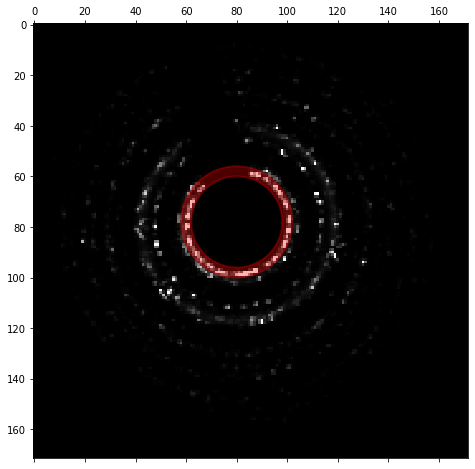

In [25]:
# Guess the center coordinate, specify the radial range for fitting peak pairs
center_guess = (78,80)
radial_range = (18,22)

# Show the ADF detector, overlaid over a new BVM
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw')
py4DSTEM.show(
    bragg_vector_map_masked, 
    clipvals='manual',
    vmin=0,
    vmax=10000,
    annulus = {
      'center':center_guess,
      'radii' : radial_range,
      'alpha':0.3,
      'fill':True
    }
)

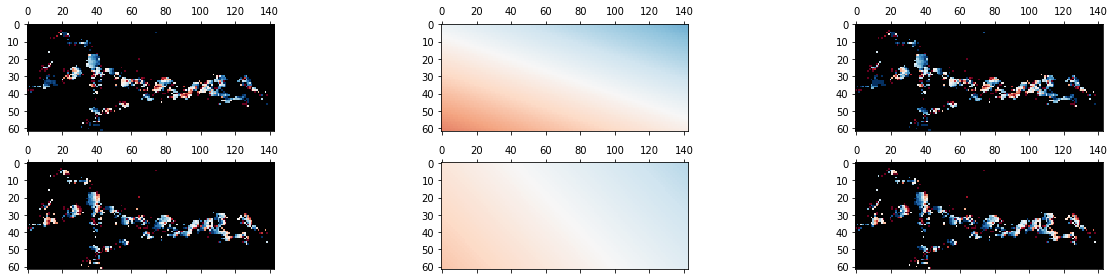

In [26]:
# Compute the origin position for all probe positions.
# This algorithm works by searching for peak pairs (Friedel symmetry) and finding the mean position of these pairs.

qxy_origins = bragg_peaks_masked.measure_origin(
    mode = 'beamstop',
    center_guess = center_guess,
    radii = radial_range,
)

# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks_masked.fit_origin()

In [27]:
# apply the calibration
bragg_peaks_masked.calibration.set_origin((qx0_fit, qy0_fit))
bragg_peaks_masked.calibrate()

# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks_masked.get_bvm()

# Ellipticity 

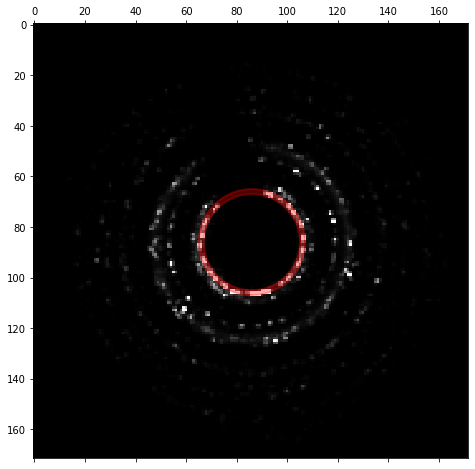

In [28]:
q_range = (19, 21)

py4DSTEM.show(
    bragg_vector_map_centered,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e4,
    annulus={
        'center':(bragg_vector_map_centered.shape[0]/2,bragg_vector_map_centered.shape[1]/2),
        'radii': q_range,'fill':True,'color':'r','alpha':0.3})

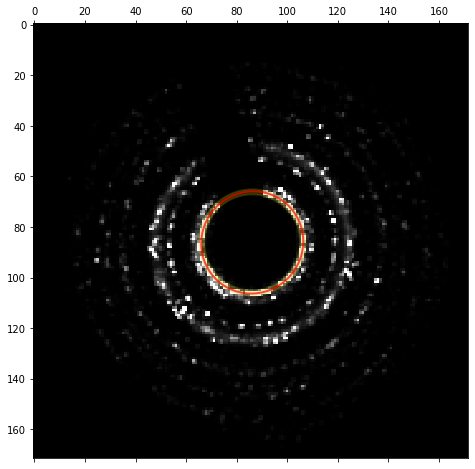

In [29]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bragg_vector_map_centered,
    fitradii = q_range,
)

# plot the fit
py4DSTEM.visualize.show_elliptical_fit(
    bragg_vector_map_centered,
    q_range,
    p_ellipse,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=4e3,
)

In [30]:
p_ellipse

(86.13045439481296,
 86.13360125781658,
 20.38903013930113,
 19.980116370015118,
 -0.7399639207428056)

In [31]:
# Apply the calibrations a
bragg_peaks_masked.calibration.set_p_ellipse(p_ellipse)
bragg_peaks_masked.calibrate()

# Rotation calibration

In [32]:
# The rotation of this dataset were determined independently (outside the scope of this notebook)
theta = -146.4067
flip = True

In [33]:
bragg_peaks_masked.calibration.set_QR_rotflip((theta, flip))
bragg_peaks_masked.calibrate()

In [34]:
# # Recompute the bvm
# bragg_vector_map_cali = bragg_peaks_masked.get_bvm()

# Pixel size calibration

In [35]:
# # Apply initial pixel size calibration
# inv_Ang_per_pixel = 0.0211
# inv_Ang_per_pixel = 0.0211

# bragg_peaks_masked.calibration.set_Q_pixel_size(inv_Ang_per_pixel)
# bragg_peaks_masked.calibration.set_Q_pixel_units('A^-1')
# bragg_peaks_masked.calibrate()

In [36]:
# Define gold structure using manual input of the crystal structure with known lattice param

a_lat = 4.08
atom_num = 79
k_max = 1.5


pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])

# Make crystal
crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    a_lat)
# Calculate structure factors
crystal.calculate_structure_factors(k_max)

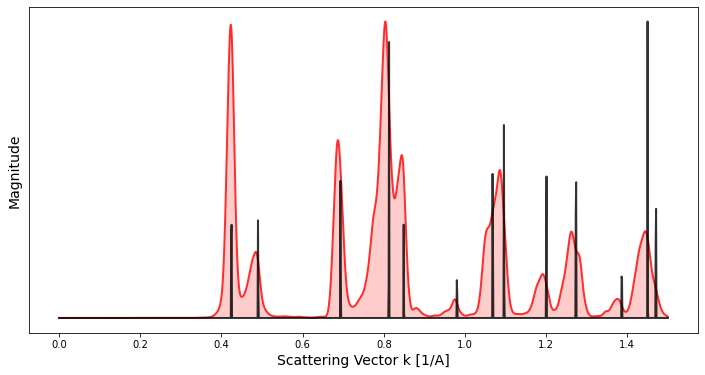

In [37]:
# Compare measured diffraction pattern with reference crystal structure
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_masked,
    bragg_k_power = 2.0,
)

/home/cophus/anaconda3/envs/py4DSTEM_dev/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Calibrated pixel size = 0.0212157 A^-1


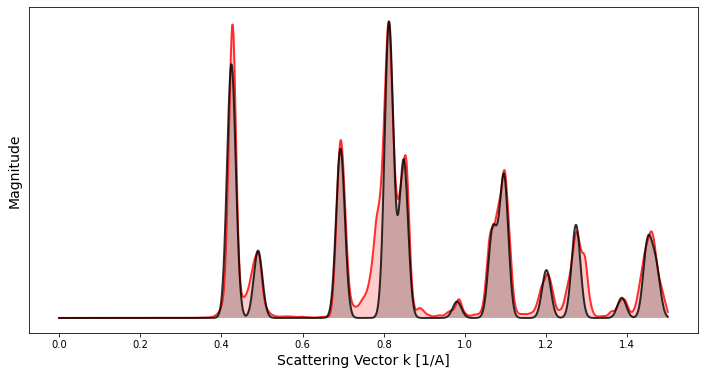

In [38]:
bragg_peaks_cali = crystal.calibrate_pixel_size(
    bragg_peaks = bragg_peaks_masked,
    bragg_k_power = 2.0,
    plot_result = True,
)

In [39]:
# Display the final calibration 
bragg_peaks_cali.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          0.02121569677921358
             R_pixel_size:          5.0
             Q_pixel_units:         A^-1
             R_pixel_units:         A
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             qx0:                   2D-array
             qy0:                   2D-array
             a:                     20.38903013930113
             b:                     19.980116370015118
             theta:                 -0.7399639207428056
             QR_rotation_degrees:   -146.4067
             QR_flip:               True
)

In [40]:
# Save calibrated Bragg peaks
file_name_braggdisks_cali = file_path_analysis + 'braggdisks_cali.h5'
py4DSTEM.save(
    file_name_braggdisks_cali,
    bragg_peaks_cali,
    mode='o',
)

100%|█████████████████████████████████████████████████████████████████████████████| 8866/8866 [00:01<00:00, 5667.25it/s]


# Automated Crystal Orientation Mapping

In [41]:
# Reload Bragg peaks if needed
file_name_braggdisks_cali = file_path_analysis + 'braggdisks_cali.h5'
py4DSTEM.io.print_h5_tree(file_name_braggdisks_cali)

/
|--4DSTEM
	|--braggvectors_copy
		|--_v_cal
		|--_v_uncal
		|--calibration




In [42]:
bragg_peaks_cali = py4DSTEM.read(
    file_name_braggdisks_cali, 
    root = '/4DSTEM/braggvectors_copy'
)
bragg_peaks_cali

Reading PointListArray: 100%|██████████████████████████████████████████████| 8866/8866 [00:01<00:00, 6091.20PointList/s]


BraggVectors( A (62, 143)-shaped array of lists of bragg vectors )

In [43]:
# Define gold structure using manual input of the crystal structure again if needed
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
atom_num = 79
a = 4.08
cell = a

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

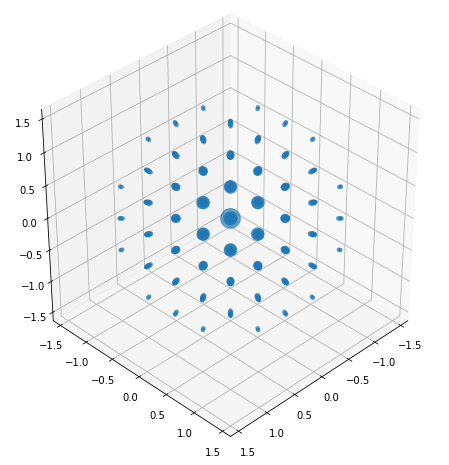

In [44]:
# Calculate and plot gold structure factors
k_max = 1.5

crystal.calculate_structure_factors(
    k_max,
)

crystal.plot_structure_factors(
    zone_axis_lattice=[1,1,1])

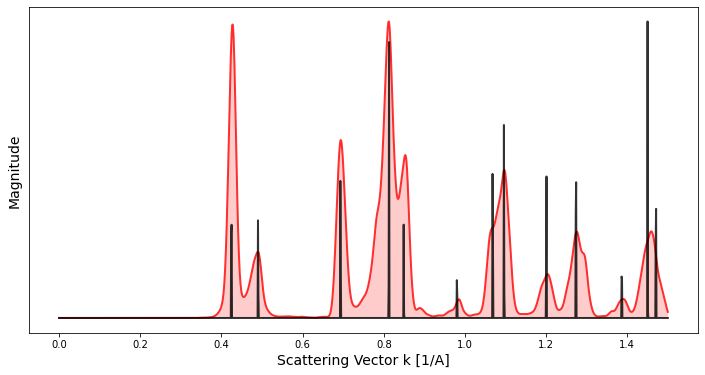

In [45]:
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_cali,
    bragg_k_power = 2.0,
)

100%|████████████████████████████████████████████████████████████████████████████| 8866/8866 [00:00<00:00, 83818.39it/s]


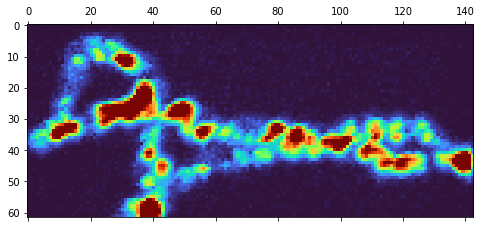

In [63]:
# Make a virtual dark field image to find the non-vacuum probe positions
im_DF = py4DSTEM.process.virtualimage.get_virtual_image_pointlistarray(
    bragg_peaks_cali.vectors,
    geometry=((),(0.3,0.6)),
)

py4DSTEM.show(
    im_DF,
    cmap='turbo',
    clipvals='manual',
    vmin=0,
    vmax=2e3,
)

In [62]:
# Create an orientation plan for gold using pymatgen

crystal.orientation_plan(
    zone_axis_range = 'auto',
#     angle_step_zone_axis = 2.0,
    #
    angle_step_zone_axis = 0.5,
    angle_coarse_zone_axis = 2.0,
    angle_refine_range = 2.0,
    #
    angle_step_in_plane = 5.0,
    accel_voltage = 300e3,
#     CUDA = True,
#     intensity_power = 0.5,
#     intensity_power = 0.125,
#     radial_power = 2.0,
#     corr_kernel_size = 0.12,
#     tol_peak_delete = 0.08,
)

Automatically detected point group m-3m,
 using arguments: zone_axis_range = 
[[0 1 1]
 [1 1 1]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|███████████████████████████████████████████████████| 5995/5995 [00:03<00:00, 1634.20 zone axes/s]


In [48]:
# # Create an orientation plan for gold without using pymatgen

# crystal.orientation_plan(
#     angle_step_zone_axis = 2.0,
#     angle_step_in_plane = 5.0,
#     accel_voltage = 300e3,
#     # intensity_power = 0.0,
# )

In [49]:
# # Plot some of the orientation plans
# fig, ax = crystal.plot_orientation_plan(
#     zone_axis_lattice=[1,3,5],
#     returnfig=True,
# );

In [50]:
import matplotlib.pyplot as plt

Best fit lattice directions: z axis = ([0.306 0.491 0.815]), x axis = ([0.562 0.566 0.603]), with corr value = 5.0
Best fit lattice directions: z axis = ([0.13  0.188 0.973]), x axis = ([0.17  0.209 0.963]), with corr value = 3.798
Best fit lattice directions: z axis = ([0.282 0.411 0.867]), x axis = ([0.208 0.215 0.954]), with corr value = 3.327
Best fit lattice directions: z axis = ([0.409 0.611 0.678]), x axis = ([0.394 0.551 0.735]), with corr value = 1.471


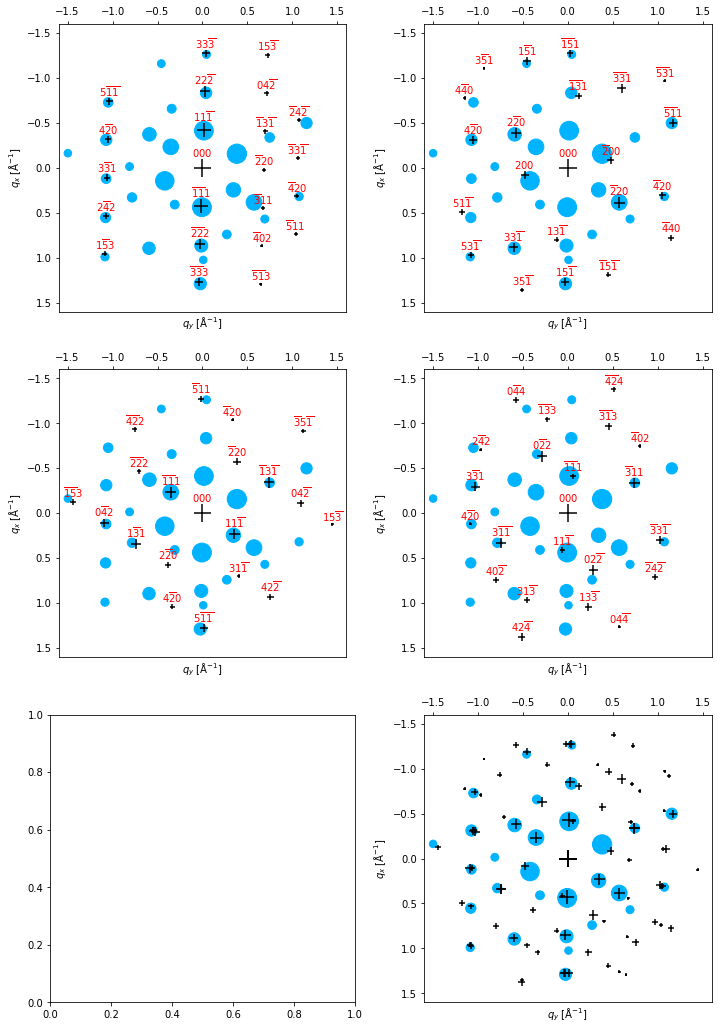

In [51]:
# Test matching on some probe positions
xind, yind = 35,12
# xind, yind = 40,93
# xind, yind = 25,35
# xind, yind = 45,120

orientation  = crystal.match_single_pattern(
    bragg_peaks_cali.vectors[xind,yind],
    num_matches_return = 4,
#     plot_corr = True,
#     plot_polar = False,
    verbose = True,
#     multiple_corr_reset=False,
)

sigma_compare = 0.03
range_plot = np.array([k_max+0.1,k_max+0.1])
figsize = (6,6)

bragg_peaks_fit_0 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)
bragg_peaks_fit_1 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=1,
    sigma_excitation_error=sigma_compare)
bragg_peaks_fit_2 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=2,
    sigma_excitation_error=sigma_compare)
bragg_peaks_fit_3 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=3,
    sigma_excitation_error=sigma_compare)


fig,ax = plt.subplots(3,2,figsize=(2*figsize[0],3*figsize[1]))

# plot comparisons
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_0,
    bragg_peaks_compare=bragg_peaks_cali.vectors[xind,yind],
    scale_markers=500,
    scale_markers_compare=20,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[0,0]]),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_1,
    bragg_peaks_compare=bragg_peaks_cali.vectors[xind,yind],
    scale_markers=500,
    scale_markers_compare=20,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[0,1]]),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_2,
    bragg_peaks_compare=bragg_peaks_cali.vectors[xind,yind],
    scale_markers=500,
    scale_markers_compare=20,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[1,0]]),
)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_3,
    bragg_peaks_compare=bragg_peaks_cali.vectors[xind,yind],
    scale_markers=500,
    scale_markers_compare=20,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[1,1]]),
)

# Plot combined bragg peaks
dtype = [
    ('qx','float64'),
    ('qy','float64'),
    ('intensity','float64'),
    ('h','int'),
    ('k','int'),
    ('l','int')
]

data = np.array([], dtype=dtype)
bragg_peaks = py4DSTEM.io.datastructure.PointList(data)

bragg_peaks.add(bragg_peaks_fit_0.data)
bragg_peaks.add(bragg_peaks_fit_1.data)
bragg_peaks.add(bragg_peaks_fit_2.data)
bragg_peaks.add(bragg_peaks_fit_3.data)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks,
    bragg_peaks_compare=bragg_peaks_cali.vectors[xind,yind],
    scale_markers=500,
    scale_markers_compare=20,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    add_labels=False,
    figsize=figsize,
    input_fig_handle=(fig,[ax[2,1]])
)

In [52]:
# Some probe positions have up to decent good matches, so we will set num_matches_return = 3.

# If you want a faster calculation, change to num_matches_return = 1.

In [53]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks_cali.vectors,
    num_matches_return = 3,
    min_number_peaks = 3,
)

Matching Orientations: 100%|████████████████████████████████████████████████| 8866/8866 [05:56<00:00, 24.87 PointList/s]


# Plot the resulting orientation maps

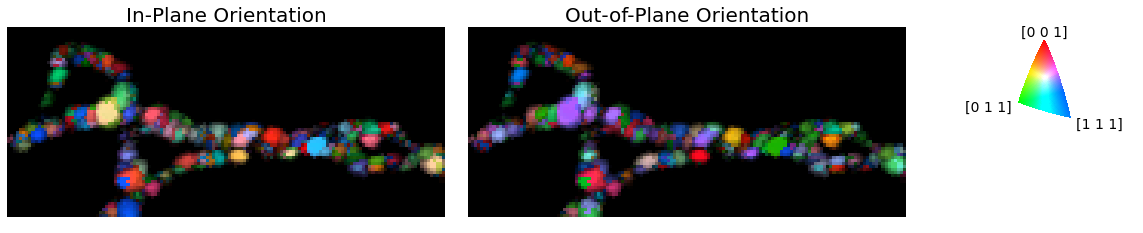

In [54]:
# plot orientation map
images_orientation = crystal.plot_orientation_maps(
    orientation_map,
    orientation_ind=0,
    corr_range = np.array([1,4]),
    camera_dist = 12,
    show_axes = False,
)

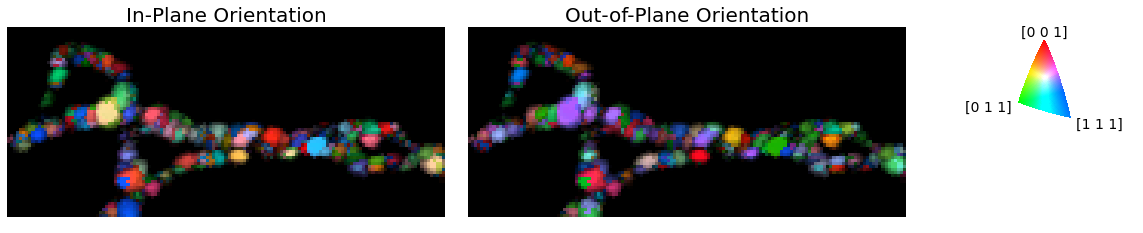

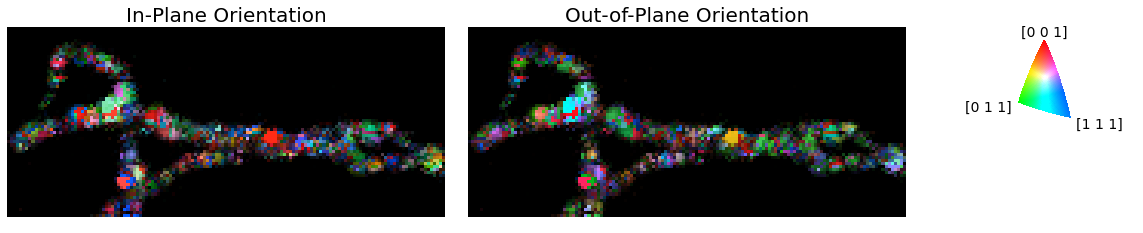

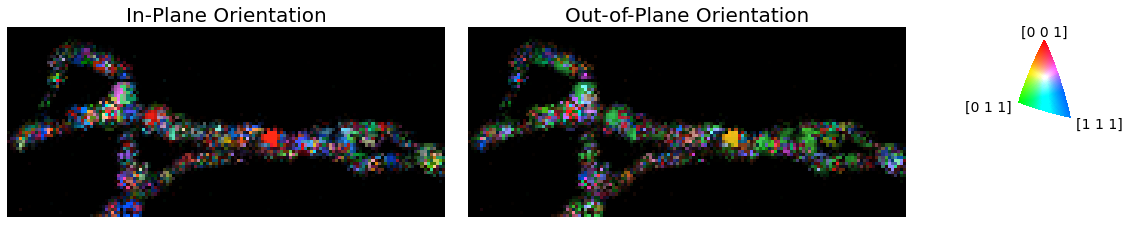

In [55]:
# plot orientation map
images_orientation = crystal.plot_orientation_maps(
    orientation_map,
    orientation_ind=0,
    corr_range = np.array([1,4]),
    camera_dist = 12,
    show_axes = False,
)
# plot orientation map
images_orientation = crystal.plot_orientation_maps(
    orientation_map,
    orientation_ind=1,
    corr_range = np.array([1,4]),
    camera_dist = 12,
    show_axes = False,
)
# plot orientation map
images_orientation = crystal.plot_orientation_maps(
    orientation_map,
    orientation_ind=2,
    corr_range = np.array([1,4]),
    camera_dist = 12,
    show_axes = False,
)

In [ ]:
# orientation_sort = py4DSTEM.process.diffraction.utils.sort_orientation_maps(
#     orientation_map,
#     sort = "cluster",
# )